# Set Directories

In [ ]:

import os

TRAIN_DIR = "/content/drive/MyDrive/PFE/UbirisV2_Dataset/Train_Dataset"
TEST_DIR = "/content/drive/MyDrive/PFE/UbirisV2_Dataset/Test_Dataset"
os.chdir(TRAIN_DIR)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: 

# Preprocess Data

In [ ]:
from __future__ import print_function

import tensorflow as tf
import os

# Dataset Parameters
MODE = 'folder' # or 'file', if you choose a plain text file (see above).
#TEST_PATH = 'MMU2/' # the dataset file or root folder path.

# Image Parameters
N_CLASSES = 50 # total number of classes
IMG_HEIGHT = 224 # the image height to be resized to
IMG_WIDTH = 224 # the image width to be resized to
CHANNELS = 3 # The 3 color channels, change to 1 if grayscale

# Loading Dataset

In [ ]:

def get_dataset(data_dir, batch_size=64, img_height=224, img_width=224):
    train_ds = tf.keras.utils.image_dataset_from_directory(
      data_dir,
      validation_split=0.2,
      subset="training",
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)

    return train_ds


# Parameters
learning_rate = 0.0010
num_steps = 1000
batch_size = 32
display_step = 100

# Network Parameters
dropout = 0.75 # Dropout, probability to keep units

train_ds = get_dataset(TRAIN_DIR, batch_size=batch_size)
test_ds = get_dataset(TEST_DIR, batch_size=batch_size)

Found 1070 files belonging to 50 classes.
Using 856 files for training.
Found 100 files belonging to 50 classes.
Using 80 files for training.


# Visualizing Images

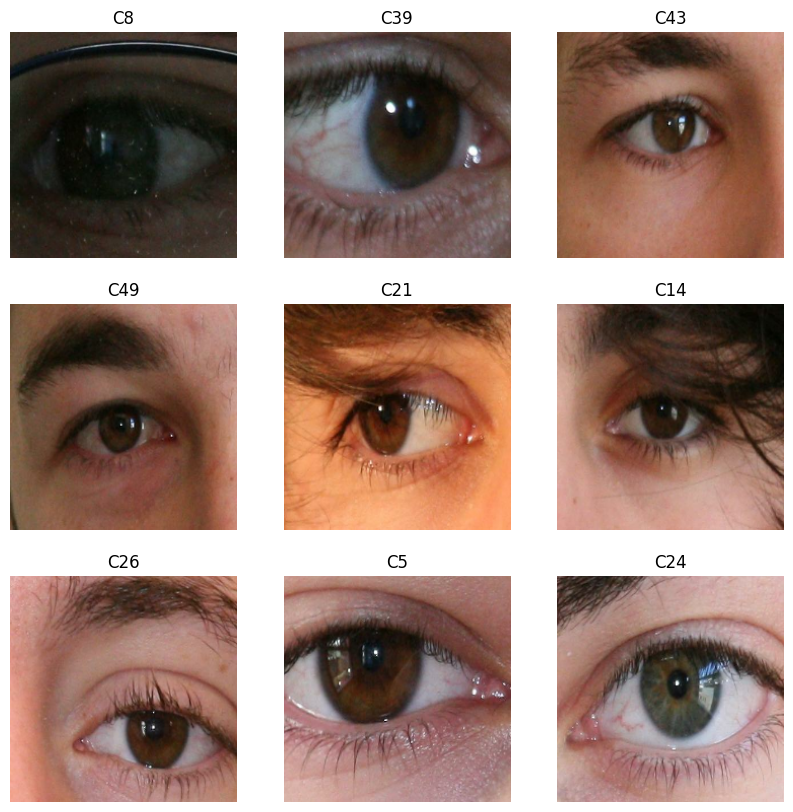

In [ ]:
# Visualizing images

class_names = train_ds.class_names

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Normalizing Data

In [ ]:
preprocess_input = tf.keras.applications.resnet.preprocess_input
# equivalent to transforming the input with: x / 127.5 - 1 (also does the work of the 2 cells above)

# Feature Extractor

In [ ]:
# Create the base model from the pre-trained model ResNet50
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


In [ ]:
# Extract features

base_model.trainable = False
base_model.summary()


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


# Classification layer
prediction_layer = tf.keras.layers.Dense(N_CLASSES)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 2048)
(32, 50)


# Create classification layer

In [ ]:
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.30)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# Compile the Model

In [ ]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 20
history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=test_ds)

Epoch 1/20
27/27 [==============================] - 302s 11s/step - loss: 4.4117 - accuracy: 0.0619 - val_loss: 3.5848 - val_accuracy: 0.0875
Epoch 2/20
27/27 [==============================] - 259s 10s/step - loss: 3.1516 - accuracy: 0.1916 - val_loss: 2.9388 - val_accuracy: 0.2625
Epoch 3/20
27/27 [==============================] - 266s 10s/step - loss: 2.5167 - accuracy: 0.3271 - val_loss: 2.4313 - val_accuracy: 0.4250
Epoch 4/20
27/27 [==============================] - 237s 9s/step - loss: 1.9773 - accuracy: 0.4650 - val_loss: 2.0324 - val_accuracy: 0.4750
Epoch 5/20
27/27 [==============================] - 272s 10s/step - loss: 1.5650 - accuracy: 0.6005 - val_loss: 1.7872 - val_accuracy: 0.5250
Epoch 6/20
27/27 [==============================] - 271s 10s/step - loss: 1.2809 - accuracy: 0.6916 - val_loss: 1.5390 - val_accuracy: 0.6000
Epoch 7/20
27/27 [==============================] - 280s 10s/step - loss: 1.1283 - accuracy: 0.7348 - val_loss: 1.3628 - val_accuracy: 0.6500
Epoch 8

In [ ]:
model.save('ResNet50')

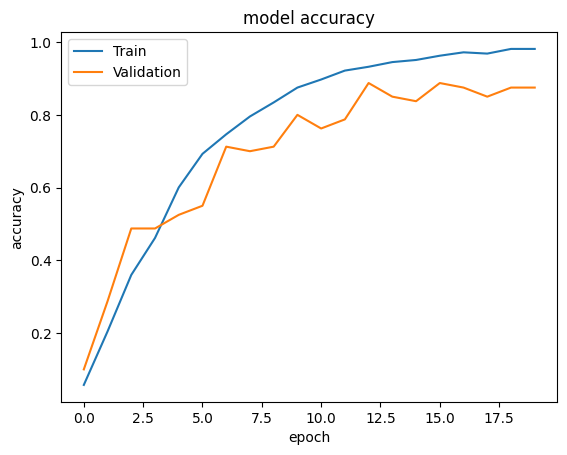

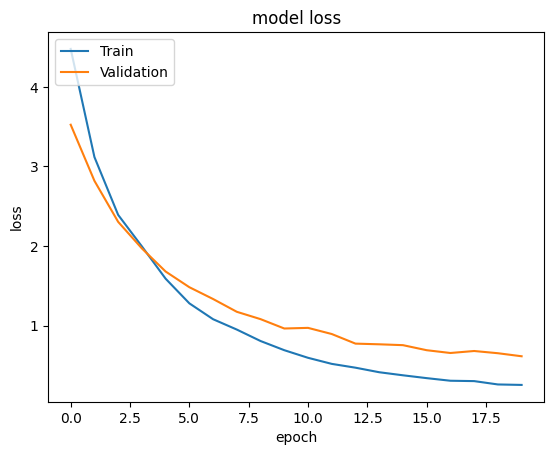

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

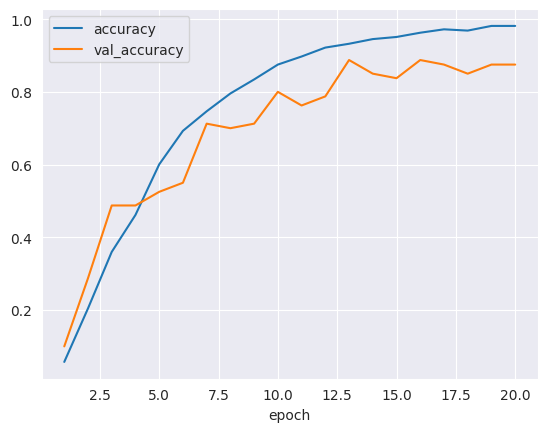

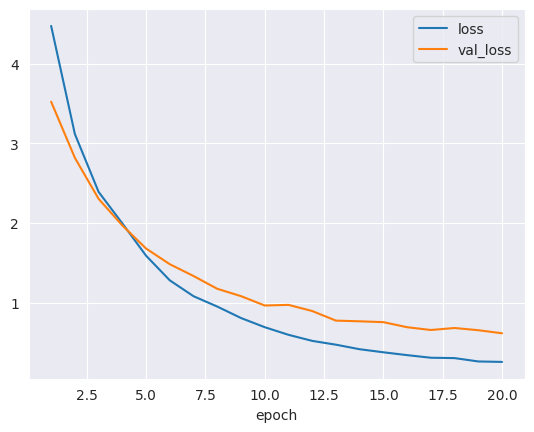

In [ ]:
import pandas as pd
import seaborn as sns

results = pd.DataFrame({
    "epoch": range(1, 21),
    "accuracy": history.history["accuracy"],
    "val_accuracy": history.history["val_accuracy"]
}).set_index("epoch")

sns.set_style("darkgrid")
sns.lineplot(results, dashes=False)
plt.show()
results = pd.DataFrame({
    "epoch": range(1, 21),
    "loss": history.history["loss"],
    "val_loss": history.history["val_loss"]
}).set_index("epoch")

sns.set_style("darkgrid")
sns.lineplot(results, dashes=False)
plt.show()

In [ ]:
!lscpu
!lsgpu

Architecture:             x86_64
  CPU op-mode(s):         32-bit, 64-bit
  Address sizes:          46 bits physical, 48 bits virtual
  Byte Order:             Little Endian
CPU(s):                   2
  On-line CPU(s) list:    0,1
Vendor ID:                GenuineIntel
  Model name:             Intel(R) Xeon(R) CPU @ 2.20GHz
    CPU family:           6
    Model:                79
    Thread(s) per core:   2
    Core(s) per socket:   1
    Socket(s):            1
    Stepping:             0
    BogoMIPS:             4400.43
    Flags:                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 cl
                          flush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc re
                          p_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3
                           fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand
                           hypervisor lahf_lm abm 3dnowprefetch i

# Creating & training a model
# WARNING: dense layer size copied from original code. Could be too big
from tensorflow.keras.models import Sequential


def create_model(n_classes, dropout, img_height, img_width):
    model = Sequential([
      layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
      layers.Conv2D(24, 5, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(48, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Flatten(),
      layers.Dense(768, activation='relu'),
      layers.Dropout(dropout),
      layers.Dense(n_classes),
      layers.Softmax()
    ])

    return model

model = create_model(N_CLASSES, dropout, img_height=240, img_width=320)
model.summary()

In [ ]:
# Training

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs=10
history = model.fit(
  train_ds,
  #validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


3/3 [==============================] - 33s 9s/step - loss: 3.8243 - accuracy: 0.0276
Epoch 2/10
3/3 [==============================] - 33s 9s/step - loss: 3.8068 - accuracy: 0.0207
Epoch 3/10
3/3 [==============================] - 30s 9s/step - loss: 3.8070 - accuracy: 0.0138
Epoch 4/10
3/3 [==============================] - 32s 9s/step - loss: 3.8067 - accuracy: 0.0069
Epoch 5/10
3/3 [==============================] - 30s 9s/step - loss: 3.8046 - accuracy: 0.0207
Epoch 6/10
3/3 [==============================] - 31s 9s/step - loss: 3.8034 - accuracy: 0.0276
Epoch 7/10
3/3 [==============================] - 30s 9s/step - loss: 3.7916 - accuracy: 0.0207
Epoch 8/10
3/3 [==============================] - 29s 9s/step - loss: 3.8017 - accuracy: 0.0207
Epoch 9/10
3/3 [==============================] - 32s 10s/step - loss: 3.7901 - accuracy: 0.0345
Epoch 10/10
3/3 [==============================] - 38s 9s/step - loss: 3.8245 - accuracy: 0.0276


In [ ]:
# Creat model
def conv_net(x, n_classes, dropout, reuse, is_training):
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):

        # Convolution Layer with 24 filters and a kernel size of 5
        conv1 = tf.layers.conv2d(x, 24, 5, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

        # Convolution Layer with 48 filters and a kernel size of 3
        conv2 = tf.layers.conv2d(conv1, 48, 3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer (in contrib folder for now)
        fc1 = tf.layers.dense(fc1, 768)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)
        # Because 'softmax_cross_entropy_with_logits' already apply softmax,
        # we only apply softmax to testing network
        out = tf.nn.softmax(out) if not is_training else out

    return out


# Because Dropout have different behavior at training and prediction time, we
# need to create 2 distinct computation graphs that share the same weights.

# Create a graph for training
logits_train = conv_net(X, N_CLASSES, dropout, reuse=False, is_training=True)
# Create another graph for testing that reuse the same weights
logits_test = conv_net(X2, N_CLASSES, dropout, reuse=True, is_training=False)

# Define loss and optimizer (with train logits, for dropout to take effect)
loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=logits_train, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

## Original code


In [ ]:
from __future__ import print_function

import tensorflow as tf
import os

# Dataset Parameters
MODE = 'folder' # or 'file', if you choose a plain text file (see above).
DATASET_PATH = 'MMU/' # the dataset file or root folder path.
TEST_PATH = 'MMU2/' # the dataset file or root folder path.

# Image Parameters
N_CLASSES = 45 # total number of classes
IMG_HEIGHT = 24 # the image height to be resized to
IMG_WIDTH = 32 # the image width to be resized to
CHANNELS = 3 # The 3 color channels, change to 1 if grayscale

# Reading the dataset
# 2 modes: 'file' or 'folder'
def read_images(dataset_path, mode, batch_size):
    imagepaths, labels = list(), list()
    if mode == 'file':
        # Read dataset file
        data = open(dataset_path, 'r').read().splitlines()
        for d in data:
            imagepaths.append(d.split(' ')[0])
            labels.append(int(d.split(' ')[1]))
    elif mode == 'folder':
        # An ID will be affected to each sub-folders by alphabetical order
        label = 0
        # List the directory
        classes = None
        print(dataset_path)
        for (path, dirs, files) in os.walk(dataset_path):
            print("Dosyalar Okunuyor")
            print(path)
            classes = sorted(dirs)
            break
        #classes = sorted(os.walk(dataset_path).__next__()[1])
        # List each sub-directory (the classes)
        for c in classes:
            c_dir = os.path.join(dataset_path, c)
            walk = os.walk(c_dir).__next__()
            # Add each image to the training set
            for sample in walk[2]:
                # Only keeps jpeg images
                if sample.endswith('.bmp'):
                    imagepaths.append(os.path.join(c_dir, sample))
                    labels.append(label)
            label += 1
    else:
        raise Exception("Unknown mode.")

    # Convert to Tensor
    imagepaths = tf.convert_to_tensor(imagepaths, dtype=tf.string)
    labels = tf.convert_to_tensor(labels, dtype=tf.int32)
    # Build a TF Queue, shuffle data
    image, label = tf.train.slice_input_producer([imagepaths, labels],
                                                 shuffle=True)

    # Read images from disk
    image = tf.read_file(image)
    image = tf.image.decode_bmp(image, channels=CHANNELS)

    # Resize images to a common size
    image = tf.image.resize_images(image, [IMG_HEIGHT, IMG_WIDTH])
    # Normalize
    image = image * 1.0/127.5 - 1.0

    # Create batches
    X, Y = tf.train.batch([image, label], batch_size=batch_size,
                          capacity=batch_size * 8,
                          num_threads=1)

    return X, Y

# Parameters
learning_rate = 0.0010
num_steps = 1000
batch_size = 64
display_step = 100

# Network Parameters
dropout = 0.75 # Dropout, probability to keep units

# Build the data input
X, Y = read_images(DATASET_PATH, MODE, batch_size)
X2, Y2 = read_images(TEST_PATH, MODE, batch_size)


# Create model
def conv_net(x, n_classes, dropout, reuse, is_training):
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):

        # Convolution Layer with 24 filters and a kernel size of 5
        conv1 = tf.layers.conv2d(x, 24, 5, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

        # Convolution Layer with 48 filters and a kernel size of 3
        conv2 = tf.layers.conv2d(conv1, 48, 3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer (in contrib folder for now)
        fc1 = tf.layers.dense(fc1, 768)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)
        # Because 'softmax_cross_entropy_with_logits' already apply softmax,
        # we only apply softmax to testing network
        out = tf.nn.softmax(out) if not is_training else out

    return out


# Because Dropout have different behavior at training and prediction time, we
# need to create 2 distinct computation graphs that share the same weights.

# Create a graph for training
logits_train = conv_net(X, N_CLASSES, dropout, reuse=False, is_training=True)
# Create another graph for testing that reuse the same weights
logits_test = conv_net(X2, N_CLASSES, dropout, reuse=True, is_training=False)

# Define loss and optimizer (with train logits, for dropout to take effect)
loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=logits_train, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model (with test logits, for dropout to be disabled)
correct_pred = tf.equal(tf.argmax(logits_test, 1), tf.cast(Y2, tf.int64))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Saver object
saver = tf.train.Saver()

# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    # Start the data queue
    tf.train.start_queue_runners()

    # Training cycle
    for step in range(1, num_steps+1):

        if step % display_step == 0:
            # Run optimization and calculate batch loss and accuracy
            _, loss, acc = sess.run([train_op, loss_op, accuracy])
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc))
        else:
            # Only run the optimization op (backprop)
            sess.run(train_op)

    # lastacc = sess.run(accuracy)
    # print("Accuracy= {:.3f}".format(lastacc))
    print("Optimization Finished!")

    # Save model
    # saver.save(sess, './my_tf_model')

    # Coordinate the loading of image files.
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)


    # Finish off the filename queue coordinator.
    coord.request_stop()
    coord.join(threads)
